# Wasserstein GAN in Pytorch

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
%matplotlib inline

First, we, set up batch size, image size, and size of noise vector:

In [2]:
bs,sz,nz = 256,64,100
PATH_G = 'model_g.pkl'
PATH_D = 'model_d.pkl'

In [3]:
PATH = '/home/m20163692/data/cifar10'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

Files already downloaded and verified


Even parallel processing is handling automatically by torch-vision.

In [4]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

196

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [5]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [6]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from dcgan_bkup import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [7]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
netG = DCGAN_G(sz, nz, 3, 64, 2, 1).cuda()
netG.apply(weights_init);

In [9]:
netD = DCGAN_D(sz, 3, 64, 2, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [10]:
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [11]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [12]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [13]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [14]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [15]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i + 1:04}/{gen_iterations + 1:04}', end='\r')
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            torch.save(netG.state_dict(), PATH_G)
            torch.save(netD.state_dict(), PATH_D)
            
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [117]:
%%time
# train(10, True) # First run
train(30, False)

[0/30][21/196] Loss_D: -1.330050 Loss_G: 0.674153 Loss_D_real: -0.709341 Loss_D_fake 0.620709
[1/30][61/196] Loss_D: -0.952432 Loss_G: 0.297842 Loss_D_real: -0.315355 Loss_D_fake 0.637077
[2/30][101/196] Loss_D: -1.219890 Loss_G: 0.682385 Loss_D_real: -0.690634 Loss_D_fake 0.529257
[3/30][141/196] Loss_D: -0.570200 Loss_G: 0.601629 Loss_D_real: -0.398993 Loss_D_fake 0.171207
[4/30][181/196] Loss_D: -0.168657 Loss_G: 0.178490 Loss_D_real: -0.678775 Loss_D_fake -0.510118
[5/30][221/196] Loss_D: -0.156450 Loss_G: 0.003591 Loss_D_real: -0.690886 Loss_D_fake -0.534436
[6/30][261/196] Loss_D: -1.054234 Loss_G: 0.665857 Loss_D_real: -0.662879 Loss_D_fake 0.391356
[7/30][301/196] Loss_D: -1.247828 Loss_G: 0.624275 Loss_D_real: -0.645515 Loss_D_fake 0.602313
[8/30][341/196] Loss_D: -0.286316 Loss_G: 0.532801 Loss_D_real: -0.667669 Loss_D_fake -0.381353
[9/30][381/196] Loss_D: -1.184080 Loss_G: 0.614735 Loss_D_real: -0.636048 Loss_D_fake 0.548032
[10/30][421/196] Loss_D: -0.819672 Loss_G: 0.6282

## View

In [16]:
# LOAD
netG.load_state_dict(torch.load(PATH_G))
netD.load_state_dict(torch.load(PATH_D))

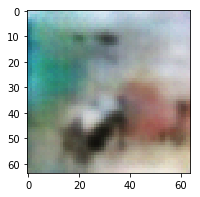

In [17]:
fixed_noise = create_noise(bs)
fake = netG(fixed_noise[:80]).data.cpu()
show(random.choice(fake), (3,3))

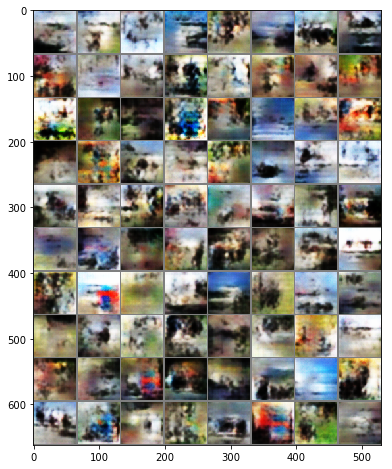

In [18]:
show(utils.make_grid(fake))

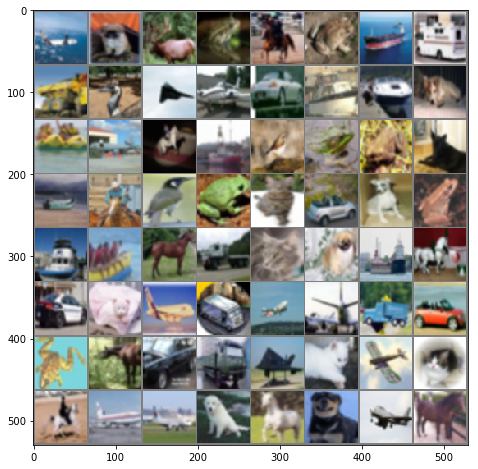

In [113]:
show(utils.make_grid(iter(dataloader).next()[0][:64]))